<a href="https://colab.research.google.com/github/khm9888/projects/blob/main/1_1_regression_sample_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **regression dataset 활용하여 분석하기**
보스턴 주택 가격 데이터





In [230]:
#0.라이브러리 임포트
#1.데이터
#2.모델구성
#3.훈련 및 검증
#4.평가 및 예측
#5.시각화


In [231]:
#0.라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
#이건 왜 하는가? 에러 안 나기 위해서 정도로 알고 있음
from matplotlib import pyplot as plt
import pandas as pd
# from tqdm import tqdm
from tqdm.notebook import tqdm

#기억 안 나는 것들.
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from keras.datasets import boston_housing

from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split

import seaborn as sns



In [232]:
t= torch.cuda.is_available()
device =torch.device("cuda" if t else "cpu")
print(t)

False


In [233]:
torch.manual_seed(1)

In [234]:
#1.데이터

#co-lab에서는 데이터 다시 넣어줘야함.


###############################################

# # data를 csv를 통해서 가져온다면 아래 방법을! ##

# data_df=pd.read_csv("candy-data.csv")

# data_df=data_df.sort_values(["winpercent"])
# print(data_df)

# data_array = data_df.values[:,1:]
# data_array = np.array(data_array,dtype=np.float64)
# print(data_array.shape)
# print(type(data_array[0][0]))

# data_torch = torch.from_numpy(data_array).float()
# # print(data_torch)
# # data_torch = torch.from_numpy(data_df).float().to(device)

# x,y = data_torch[:,:11],data_torch[:,11:]

###############################################

data = boston_housing.load_data()

(x_train,y_train),(x_test,y_test)=data

y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

#scaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
# x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
x_train, y_train = np.array(x_train), np.array(y_train)
# x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)







In [235]:
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

print(x_train.size())
print(y_train.size())


torch.Size([404, 13])
torch.Size([404, 1])


In [236]:
batch_count = 5
# BATCH_SIZE = 64

dataset_train = TensorDataset(x_train,y_train)
dataloader_train = DataLoader(dataset_train,batch_size=(x_train.size()[0]+batch_count)//batch_count,shuffle=True)

dataset_valid = TensorDataset(x_test,y_test)
dataloader_valid = DataLoader(dataset_valid,batch_size=(x_train.size()[0]+batch_count)//batch_count,shuffle=True)


In [237]:
#2.모델구성


print(x_train.size()[1])
print(y_train.size()[1])

class Multivariate_LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(in_features=x_train.size()[1],out_features=100)
        self.linear2=nn.Linear(100,1000)
        self.linear3=nn.Linear(1000,100)
        self.linear4=nn.Linear(100,10)
        self.linear5=nn.Linear(in_features=10,out_features=y_train.size()[1])
        # self.linear=nn.Linear(3,1)

    def forward(self,x): #기본적으로는 함수형, 그러나 sequential 하게도 넣을 수 있음.
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

# model = nn.Linear(in_features=x_train.size()[1], out_features=y_train.size()[1])
# model = nn.Linear(in_features=3, out_features=1, bias=False)

model = Multivariate_LinearRegressionModel().to(device)

# SGD의 optimizer상에서 정의한 네트워크의 
# 파라미터를 전달해서 초기화

# LEARNING_RATE = 0.001 #1e-3

optimizer = optim.SGD(model.parameters(), lr=1e-5)#
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# MSE loss클래스
loss_fn = nn.MSELoss()
#loss_fn = F.mse_loss #F쪽에 있는 loss_fn을 써도 무방하다.



13
1


In [243]:
#3.훈련 및 검증
loss_stats = {"train":[],"valid":[]}

epochs = 2000
min_valid_loss = np.inf

for epoch in tqdm(range(1,epochs+1)):
# for epoch in (range(1,epochs+1)):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for batch_idx, samples in enumerate(dataloader_train):

        # 전회의 backward 메서드로 계산된 경사 값을 초기화
        x_train_b, y_train_b = samples
        # x_train_b, y_train_b = x_train_b.float(), y_train_b.float()
        optimizer.zero_grad()

        # 선형 모델으로 y 예측 값을 계산
        y_pred = model(x_train_b)

        loss = loss_fn(y_pred.view_as(y_train_b),y_train_b)
        #view_as를 써서 차원을 맞춘다고 하는데. 이번엔 효과없음
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()       
    
    loss_stats["train"].append(train_loss/len(dataloader_train))
    loss_stats["valid"].append(valid_loss/len(dataloader_valid))

    # if epoch == 1:
    #     print("y_pred")
    #     print(y_pred)
    #     print("y_train_b")
    #     print(y_train_b)
    #     print(loss)

######################################################################
    with torch.no_grad():
        valid_loss = 0.0
        model.eval()     # Optional when not using Model Specific layer
        for batch_idx, samples in enumerate(dataloader_valid):

            # 전회의 backward 메서드로 계산된 경사 값을 초기화
            x_test_b, y_test_b = samples
            # x_test_b, y_test_b = x_test_b.float(), y_test_b.float()

            # 선형 모델으로 y 예측 값을 계산
            y_pred = model(x_test_b)

            loss = loss_fn(y_pred.view_as(y_test_b),y_test_b)
            #view_as를 써서 차원을 맞춘다고 하는데. 이번엔 효과없음
            
            valid_loss+=loss.item()    
        valid_losses.append(valid_loss)
    if epoch%(epochs//100)==0:
        print(f'Epoch {epoch} \t\t Training Loss: {train_loss / len(dataloader_train)} \t\t Validation Loss: {valid_loss / len(dataloader_valid)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

  0%|          | 0/2000 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->54.441853) 	 Saving The Model
Validation Loss Decreased(54.441853--->45.136417) 	 Saving The Model
Epoch 20 		 Training Loss: 28.65042724609375 		 Validation Loss: 22.057025909423828
Validation Loss Decreased(45.136417--->44.114052) 	 Saving The Model
Epoch 40 		 Training Loss: 28.44571723937988 		 Validation Loss: 22.123618602752686
Validation Loss Decreased(44.114052--->43.445604) 	 Saving The Model
Validation Loss Decreased(43.445604--->41.936310) 	 Saving The Model
Epoch 60 		 Training Loss: 28.099042892456055 		 Validation Loss: 23.433987617492676
Validation Loss Decreased(41.936310--->40.747835) 	 Saving The Model
Epoch 80 		 Training Loss: 27.828351974487305 		 Validation Loss: 26.618383407592773
Epoch 100 		 Training Loss: 27.614086532592772 		 Validation Loss: 37.05860424041748
Validation Loss Decreased(40.747835--->40.349232) 	 Saving The Model
Epoch 120 		 Training Loss: 27.305669403076173 		 Validation Loss: 25.419690132141113
Epoch 140 		 T

In [245]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor)
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print("-"*100)

print()
# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name)
    print(var_name, "\t", optimizer.state_dict()[var_name])
    print("-"*100)

Model's state_dict:
linear1.weight
linear1.weight 	 torch.Size([100, 13])
----------------------------------------------------------------------------------------------------
linear1.bias
linear1.bias 	 torch.Size([100])
----------------------------------------------------------------------------------------------------
linear2.weight
linear2.weight 	 torch.Size([1000, 100])
----------------------------------------------------------------------------------------------------
linear2.bias
linear2.bias 	 torch.Size([1000])
----------------------------------------------------------------------------------------------------
linear3.weight
linear3.weight 	 torch.Size([100, 1000])
----------------------------------------------------------------------------------------------------
linear3.bias
linear3.bias 	 torch.Size([100])
----------------------------------------------------------------------------------------------------
linear4.weight
linear4.weight 	 torch.Size([10, 100])
---------------

In [240]:
# # 경로 지정
# PATH = "state_dict_model.pt"

# # 저장하기
# torch.save(model.state_dict(), PATH)

# # 불러오기
# model = Multivariate_LinearRegressionModel()
# model.load_state_dict(torch.load(PATH))
# v=model.eval()
# print(v)

# #5. 전체 모델을 저장하고 불러오기

# # 경로 지정
# PATH = "entire_model.pt"

# # 저장하기
# torch.save(model, PATH)

# # 불러오기
# model = torch.load(PATH)
# v=model.eval()
# print(v)


# model.eval()
# # - 또는 -
# model.train()

In [246]:
#4.평가 및 예측
with torch.no_grad():
    model.eval()
    y_predict = model(x_test)


    # loss = loss_fn(y_predict,y_test)
    # y_predict = y_predict.detach().numpy().reshape(y_predict.size()[0])
    # y_test = y_test.detach().numpy().reshape(y_test.size()[0])
    print("y_predict")
    print(y_predict)
    print("y_test")
    print(y_test)
    print("loss")
    print(loss)

    print("r2score")
    mse = mean_squared_error(y_test, y_predict)
    r_square = r2_score(y_test, y_predict)
    print("Mean Squared Error :",mse)
    print("R^2 :",r_square)
    print(f"{y_predict}")


y_predict
tensor([[11.0199],
        [17.8189],
        [20.7819],
        [34.2902],
        [24.0043],
        [18.7064],
        [28.0312],
        [23.4007],
        [19.2122],
        [21.7390],
        [17.8913],
        [18.2115],
        [17.1649],
        [38.4741],
        [17.0518],
        [20.4560],
        [25.0252],
        [20.9429],
        [19.7579],
        [26.3075],
        [12.2836],
        [14.1181],
        [19.6828],
        [14.3882],
        [21.6294],
        [23.6161],
        [34.0719],
        [28.7682],
        [12.5036],
        [20.7962],
        [20.2574],
        [15.8086],
        [36.5335],
        [23.5966],
        [17.9164],
        [10.3376],
        [14.9031],
        [18.5256],
        [18.8008],
        [27.2835],
        [26.6896],
        [27.0932],
        [17.1229],
        [35.9882],
        [31.2942],
        [22.4479],
        [28.3003],
        [16.9699],
        [23.4278],
        [22.8135],
        [32.1758],
        [18.5146],
  

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

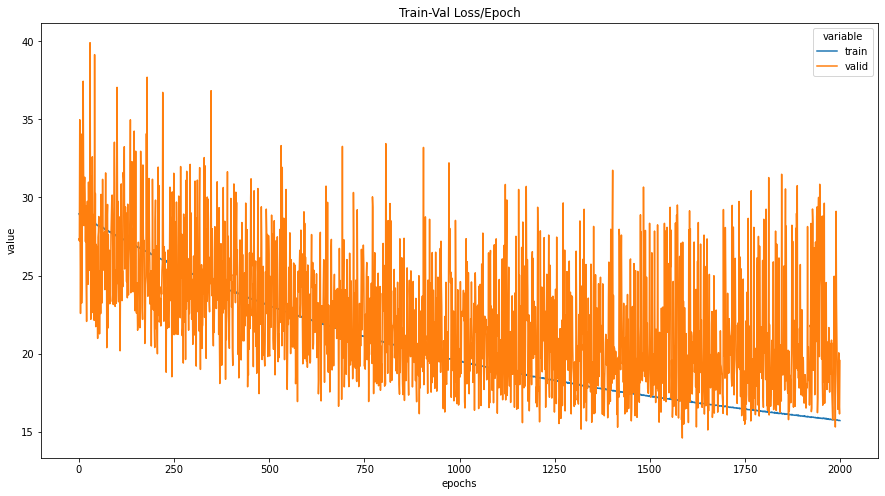

In [247]:
#5.시각화

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')


# plt.plot(train_losses[50::20])
# plt.plot(valid_losses[50::20])